# An investigation into Energy Consumption Using Time Series 

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette() #use the color palette
plt.style.use('fivethirtyeight')

In [152]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

### 1. Analysis

In [153]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [154]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


Different types of time series data, depending on data trend, etc.

In [155]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


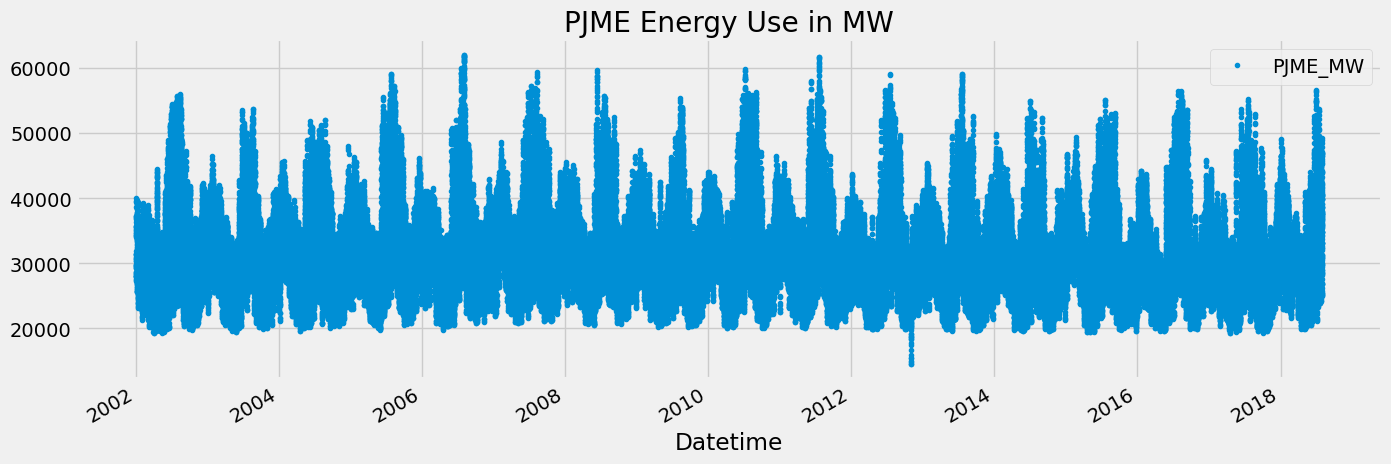

In [156]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

### 2. Train/Test/Split

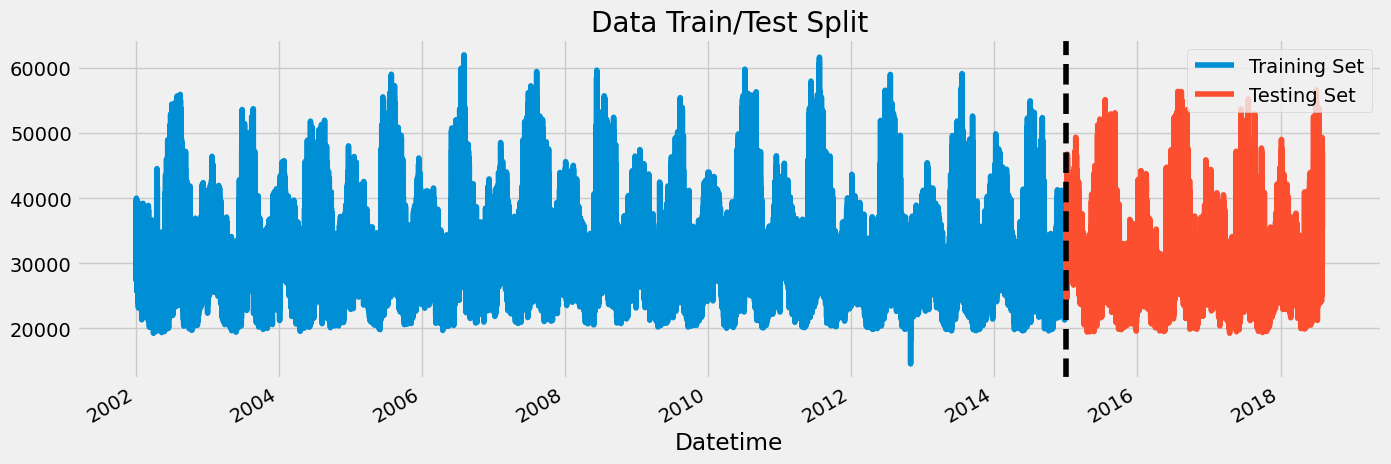

In [157]:
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Train', title='Data Train/Test Split')
test.plot(ax=ax, label='Test')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Testing Set'])
plt.show()

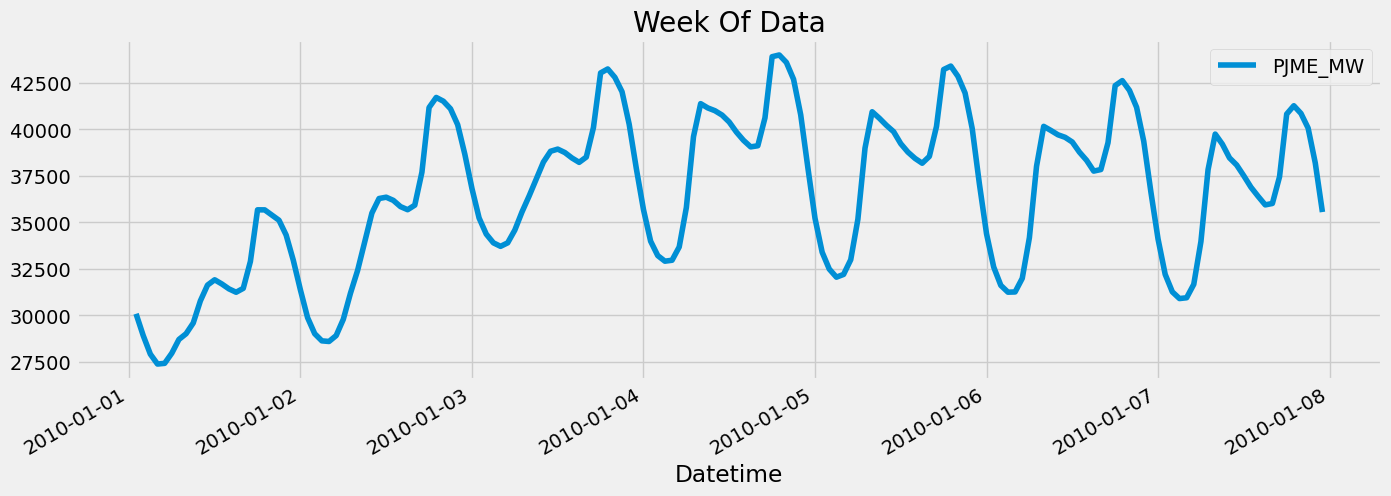

In [158]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week Of Data')
plt.show()

### 3. Feature Creation

In [159]:
def create_features(df):
    '''
    Create time series features based on the time series index
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [160]:
df = create_features(df)

### 4. Visualise our Feature/Target relationship

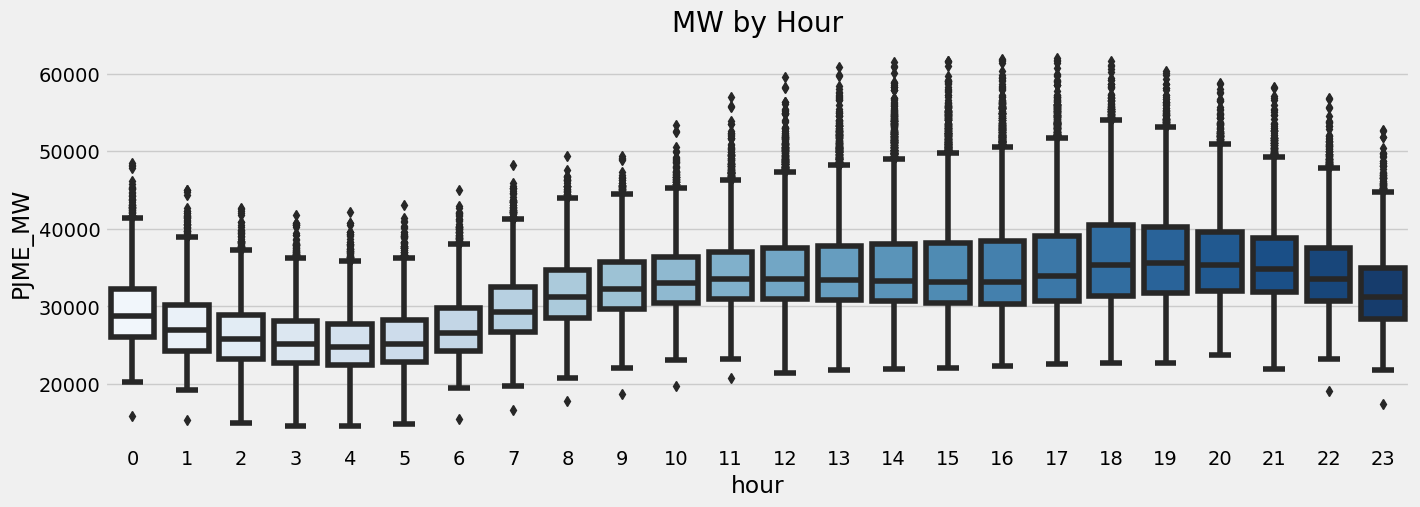

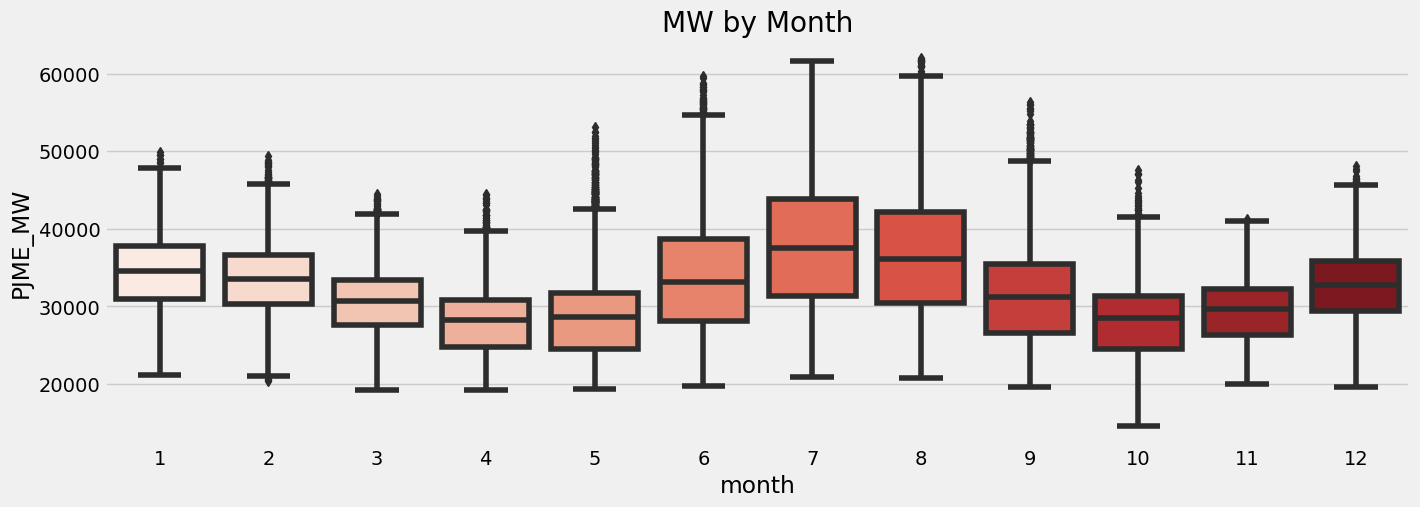

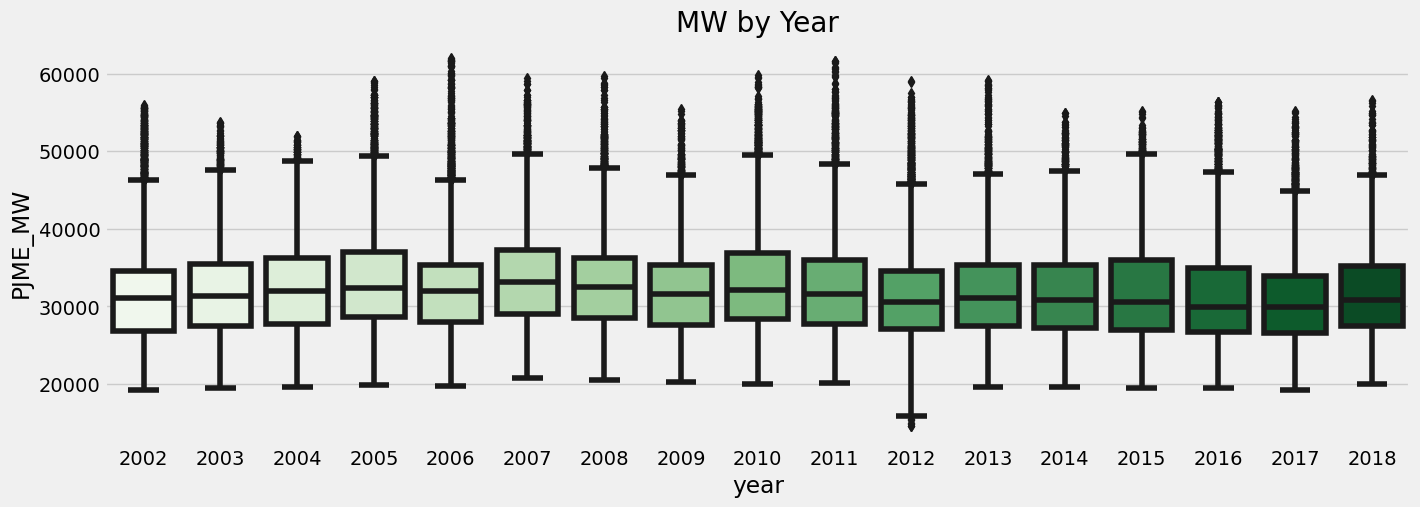

In [161]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Blues')
ax.set_title('MW by Hour')
plt.show()
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Reds')
ax.set_title('MW by Month')
plt.show()
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='year', y='PJME_MW', palette='Greens')
ax.set_title('MW by Year')
plt.show()

### 5. Create Our Model

In [199]:
train = create_features(train)
test = create_features(test)

In [200]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [201]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [202]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50,
                      learning_rate=0.01)
reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[450]	validation_0-rmse:2771.93085	validation_1-rmse:3730.77469


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### 6. Feature Importance

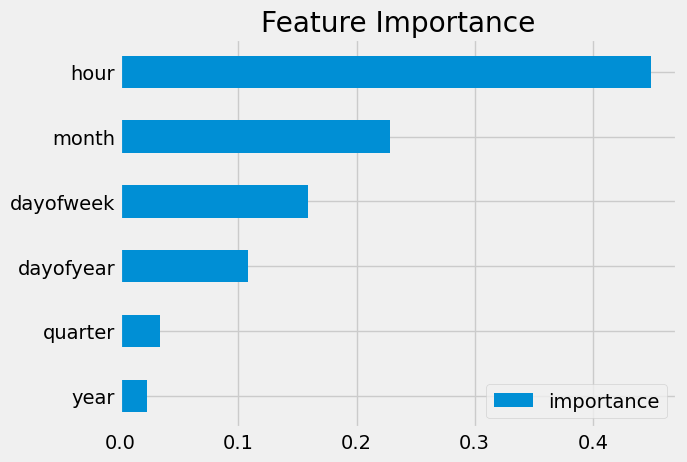

In [203]:
fi = pd.DataFrame(reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### 7. Forecast on Test

In [221]:
test['prediction']=reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)

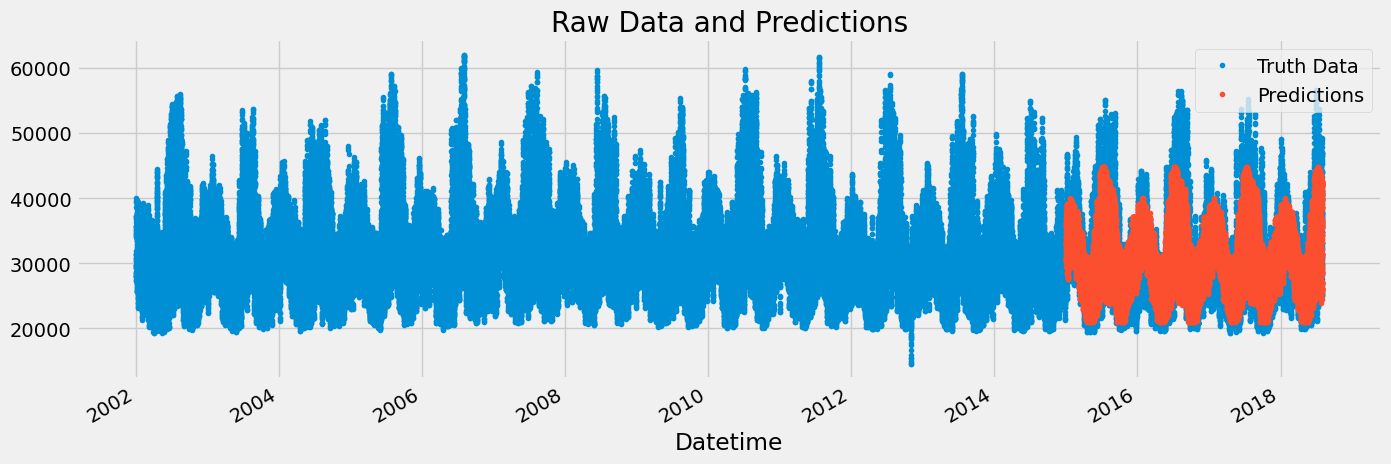

In [222]:
ax = df[['PJME_MW']].plot(figsize=(15,5), style='.')
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

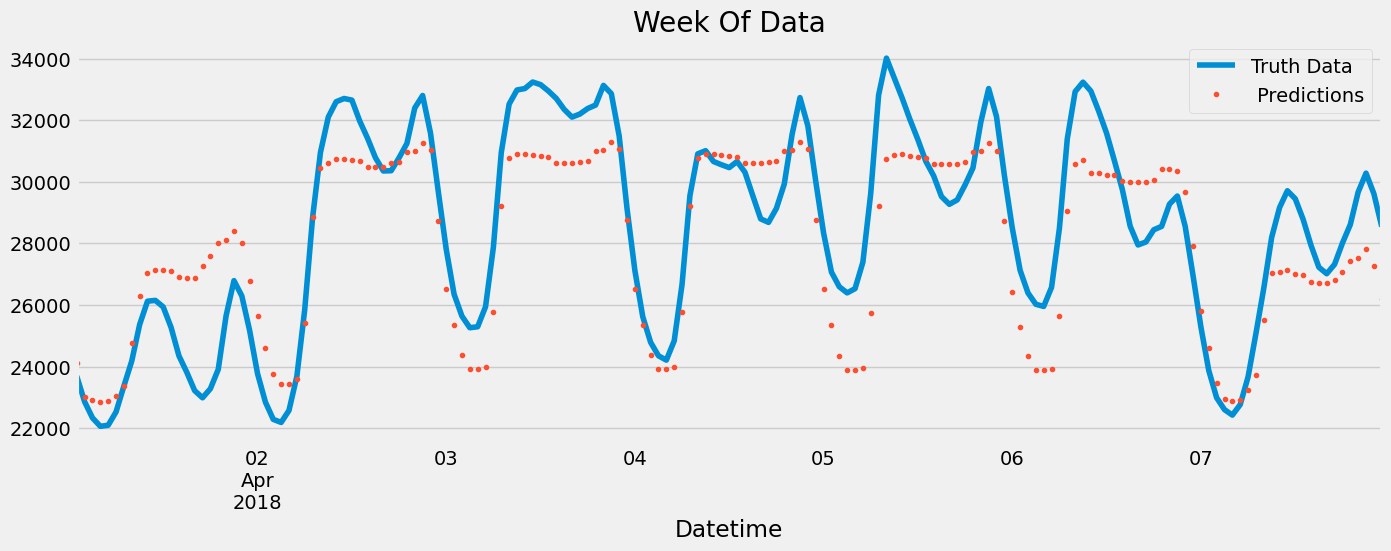

In [238]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
.plot(figsize=(15,5), title='Week Of Data')
df.loc[(df.index > '04-01-2018')&(df.index < '04-08-2018')]['prediction']\
.plot(style='.')
plt.legend(['Truth Data',' Predictions'])
plt.show()

> 1. Parameter tuning
> 2. Holiday day inclusion

In [242]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93


### 8. Calculate Error
- Look at the worst and best predicted dates

In [245]:
test['error']=np.abs(test['PJME_MW']-test['prediction'])

In [248]:
test['date'] = test.index.date

Worst predictions seem to be in the middle of August 2016

In [255]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

While some of best predictions were in 2016 as well.

In [257]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

### Next steps:
- Create robust corss validation
- Add more features (weather forecast, holidays) and add to the model, see how it improves things